# ADF for inference.
---
Start with explaining the core sampling operations.
1. Convolution of gaussians.
2. Greater than operator.

Then introduce the clutter problem as a motivational example.
1. Define the clutter problem as proposed by Minka in his paper.
2. Tease out why exact inference will be a problem even for a modestly sized dataset.
3. Present ADF as a solution.
4. Technical details of AFD.
5. Derive update equations.
6. Solve the clutter problem.

In [1]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this Jupyter notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

# Useful operations.
---

## 1. Convolution.
\begin{align}
Skill & \sim \mathcal{N}(Skill;\ \mu_s,\,\sigma_s) \\
Performance & \sim \mathcal{N}(Performance;\ Skill,\,\sigma_p) \\
\end{align}

A player's $Skill$ is Normally distributed around a mean skill $\mu_s$ with uncertainity(*standard deviation*) $\sigma_s$. For a completely unknown player, the uncertainity will be large before the evaluation begins and will eventually decrease. A player's performance on game day can vary based on a number of external factors, all of which are assumed to be incorporated in a player's $Performance$ which is also normally distributed around his $Skill$. The uncertainity($\sigma_p$) around the performance can be interpreted as a player's consistency. A consistent player will more often than not, exhibit a performance which is very close to his true skill.

### - Numerical(quantised) computation.
Obtaining a distribution over a player's $Performance: Perf_i$ is straightforward. Seed the player's $Skill: Skill_i$ with a mean and std. Then sample from $Skill_i$. Every $j^{th}$ sampled skill $Skill^j_i$ will serve as the mean for a performance variable $Perf^j_i$. Averaging all performances will give the approximated distribution over the performance.

In [25]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
np.random.seed(1234)

In [26]:
from scipy.stats import norm

In [62]:
s1 = norm(4, np.sqrt(9))

Plotting some random performance distributions whose mean is sampled from the skill distribution.


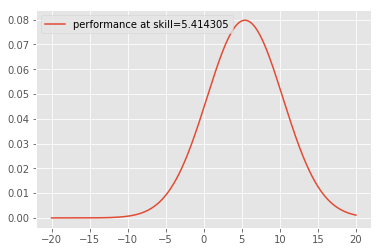

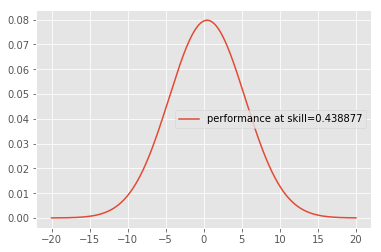

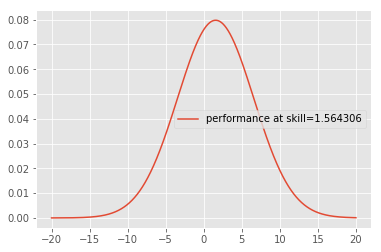

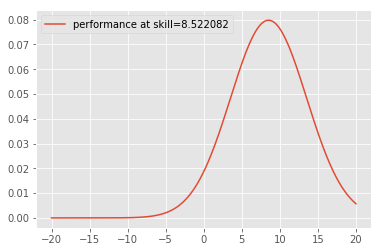

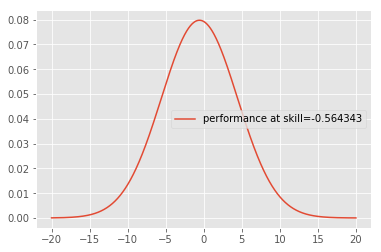

In [63]:
arr = []
print "Plotting some random performance distributions whose mean is sampled from the skill distribution."
for ix in range(5000):    
    vs1 = s1.rvs()
    xs1 = np.linspace(-20, 20, 5000)
    
    p1 = norm(vs1, np.sqrt(25))
    vp1 = p1.rvs()
    xp1 = np.linspace(-20, 20, 5000)
    
    arr.append(p1.pdf(xp1))
    
    if ix%1000==0:
        plt.figure()
        plt.plot(xp1, p1.pdf(xp1), label="performance at skill=%f"%vs1)
        plt.legend()

The approximate performance peaks at: 4.06881376275


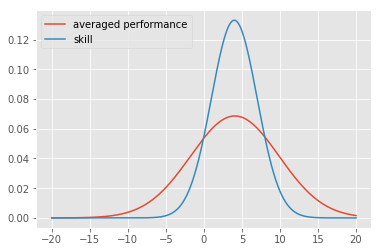

In [64]:
avg = np.mean(np.array(arr), axis=0)
plt.plot(xp1, avg, label="averaged performance")
plt.plot(xs1, s1.pdf(xs1), label="skill")
plt.legend();

print "The approximate performance peaks at:", xp1[np.argmax(avg)]

The approximate mean turns out to be 4.06; the true skill is 4.

### - Analytic computation.
With a more concrete example, we can arrive at the marginal distribution over performance variable $e$: $p(e)$ given:

\begin{align}
p(s) & = \mathcal{N}(s;\ \mu_s,\,\sigma_s^2) \\
p(e|s) & = \mathcal{N}(e;\ s,\,\sigma_e^2) \\
\end{align}

\begin{align}
& p(e) = \int_s\ p(e|s)\ p(s)\ ds \tag{0.1} \\
& = \int_s\ \mathcal{N}(e;\ s,\,v_e) \ \mathcal{N}(s;\ m_s,\,v_s) \ ds \tag{switching $m$ for $\mu$ and $v$ for $\sigma^2$} \\
& = \frac{1}{\sqrt{2{\pi}v_e}} \frac{1}{\sqrt{2{\pi}v_s}} \int_s \exp \Big(- \frac{(e-s)^2}{2v_e} \Big) \ \Big(- \frac{(s - m_s)^2}{2v_e} \Big)\ ds  \\
& = \frac{1}{\sqrt{2{\pi}v_e}} \frac{1}{\sqrt{2{\pi}v_s}} \int_s \exp \Big\{-\frac{1}{2} \Big( \frac{(e-s)^2}{v_e} + \frac{(s - m_s)^2}{v_s} \Big) \Big\} \ ds  \\
& = \frac{1}{\sqrt{2{\pi}v_e}} \frac{1}{\sqrt{2{\pi}v_s}} \int_s \exp \Big\{-\frac{1}{2 v_s v_e} \Big( v_s(e-s)^2 + v_e(s-m_s)^2 \Big) \Big\} \ ds  \\
& = \frac{1}{\sqrt{2{\pi}v_e}} \frac{1}{\sqrt{2{\pi}v_s}} \int_s \exp \Big\{-\frac{1}{2 v_s v_e} \Big( s^2(v_s + v_e) -2s(v_se + v_em_s) + v_s e^2 + v_e m_s^2 \Big) \Big\} \ ds  \\
& \ completing\ the\ squares\ and\ simplifying... \\
& = \frac{1}{\sqrt{2{\pi}v_e}} \frac{1}{\sqrt{2{\pi}v_s}} \int_s \exp \Big\{-\frac{1}{2 v_s v_e} \Big\{(v_s + v_e) \Big( s - \frac{v_se + v_em_s}{v_s + v_e} \Big)^2 + \frac{v_s v_e}{v_s + v_m}(e - m_s)^2 \Big\} \Big\}\ \ ds  \\
& = \frac{1}{\sqrt{2{\pi}v_e}} \frac{1}{\sqrt{2{\pi}v_s}} \exp \Big\{  -\frac{(e - m_s)^2}{2(v_s + v_e)}  \Big\}  \int_s \exp \Big\{-\frac{v_s + v_e}{2 v_s v_e} \Big( s - \frac{v_se + v_em_s}{v_s + v_e} \Big)^2 \Big\}\ ds  \\
&\ integrating\ gaussian\ of\ type:\ \int e^{-a(x+b)^2}dx  \\
& = \frac{1}{\sqrt{2{\pi}v_e}} \frac{1}{\sqrt{2{\pi}v_s}} \exp \Big\{  -\frac{(e - m_s)^2}{2(v_s + v_e)}  \Big\} \sqrt{\frac{2 v_s v_e}{v_s + v_e}}   \\
& = \frac{1}{\sqrt{2{\pi}(v_s + v_e)}} \exp \Big\{  -\frac{(e - m_s)^2}{2(v_s + v_e)}  \Big\}  \\
& = \mathcal{N}(e;\ m_s,\ v_e + v_s) \\
\end{align}

We can now plot the exact performance distribution against the approximate one.

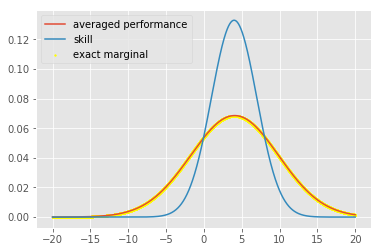

In [66]:
plt.plot(xp1, avg, label="averaged performance")
plt.plot(xs1, s1.pdf(xs1), label="skill")
analytic_posterior = norm(s1.mean(), np.sqrt(s1.var()+p1.var()))

plt.scatter(xs1, analytic_posterior.pdf(xs1), label="exact marginal", s=3, c="yellow")

plt.legend();

As evident from the figure, the approximation(*red*) is very similar to the exact distribution(*yellow*). However, this "closeness" is dependent on the sampling.

## 2. Greater than.
Assume that the skills of two players (or teams) are known. As demonstrated before, the performances will be normally distributed around said skills. Assuming $perf_{t_1} = 50$ and $perf_{t_2} = 60$ - where $perf_{t_i}$ represents performance of team $i$ - with deviation for both set to $3$, we can plot the distribution over performances as follows.

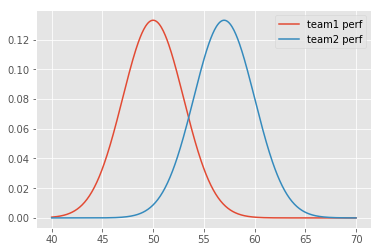

In [17]:
t1 = norm(50, 3)
t2 = norm(57, 3)
xst = np.linspace(40, 70, 500)

plt.plot(xst, t1.pdf(xst), label="team1 perf")
plt.plot(xst, t2.pdf(xst), label="team2 perf")
plt.legend();

Judging by the plots, it appears that team2 is more likely to win (on average) than team1. This "likelihood" of winning can be computed numerically by sampling for each performance variable.

In [20]:
print "Probability of team2 winning against team1:", np.mean([t2.rvs()>t1.rvs() for _ in xrange(10000)])

Probability of team2 winning against team1: 0.9509


Since the performances are normally distributed, the difference between the random variables is also normally distributed. 

In [21]:
team_diff = [t2.rvs() - t1.rvs() for _ in xrange(10000)]

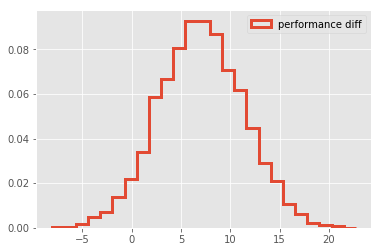

In [34]:
plt.hist(team_diff, bins=25, normed=True, histtype="step", linewidth=3, label="performance diff")
plt.legend();

To be precise, the difference is a normal distribution whose mean is the difference of the mean performances and whose variance is the sum of the team's variances.
$$ p(d = perf_{t_2} > perf_{t_1}) = \mathcal{N}(d;\ \mu_{perf_{t_2}} - \mu_{perf_{t_1}} , \sigma_{perf_{t_2}}^2 + \sigma_{perf_{t_1}}^2) $$

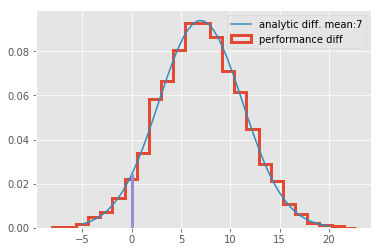

In [38]:
plt.hist(team_diff, bins=25, normed=True, histtype="step", linewidth=3, label="performance diff")
tdiff = norm(t2.mean() - t1.mean(), np.sqrt(t1.var() + t2.var()))
plt.plot(np.linspace(-5, 20), tdiff.pdf(np.linspace(-5, 20)), label="analytic diff. mean:7")

plt.plot([0, 0], [0, tdiff.pdf(0)], linewidth=3)

plt.legend();

And the exact probability of winning is the area under the curve after the purple line. 

In [40]:
print "Exact probability of winning:", 1 - tdiff.cdf(0)

Exact probability of winning: 0.95051992299


# The clutter problem.
---
## 1. Problem statement.
As presented in Minka's paper, the clutter problem is defined as follows. We are given observations from a normal distribution in a noisy environment. The observation density is thus, a mixture of the generator(*true gaussian*) and the noise(*assumed to be another gaussian*).

\begin{align}
p(x|\theta) & = (1-w)\mathcal{N}(x;\ \theta,\, 1) + w\mathcal{N}(x;\ 0,\,10) \tag{1.1} \\
p(\theta) & = \mathcal{N}(\theta;\ 0, 100) \tag{1.2} \\
\end{align}

Here, $w$ is the mixing constant know as the ratio of clutter and $\theta$ is the parameter of interest which we have to infer from the observed data. The second equation defines a (weak)prior over $\theta$. Here is the factor graph for the clutter problem.

***Clutter problem factor graph.***
![](media/clutter_problem_factor_graph.png)

### 1.1. Sampling.
We can plot density function $p(x|\theta)$ in [eq 1.1]() to get a sense of which points are more likely to occur. We set $w = 0.5$ and $\theta = 2$ as defined in the paper.

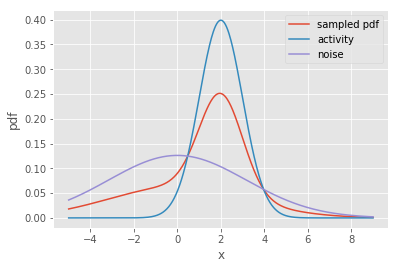

In [27]:
def gaussian_pdf(x, m, v):
    return (1.0/np.sqrt(2*np.pi*v)) * np.exp((-1.0) * np.square(x - m)/(2*v))
def likelihood(x):
    return 0.5*gaussian_pdf(x, 2, 1) + 0.5*gaussian_pdf(x, 0, 10)

xs = np.linspace(-5, 9, 500)
plt.plot(xs, likelihood(xs), label="sampled pdf")
plt.plot(xs, gaussian_pdf(xs, 2, 1), label="activity")
plt.plot(xs, gaussian_pdf(xs, 0, 10), label="noise")
plt.xlabel("x")
plt.ylabel("pdf")
plt.legend();

Eventually, we will fit some data sampled from the likelihood to estimate $\theta$. Thankfully, `scipy.stats.rv_continuous` allows us to create a random variable from a arbitrary density function. With that it exposes `.rvs()` for sampling.

In [30]:
from scipy.stats import rv_continuous
class noise_generator(rv_continuous):
    "PDF p(x | theta)"
    def _pdf(self, x):
        return likelihood(x)
    
var_obs = noise_generator(name="var_obs")
sampled_data = np.sort(var_obs.rvs(size=300))

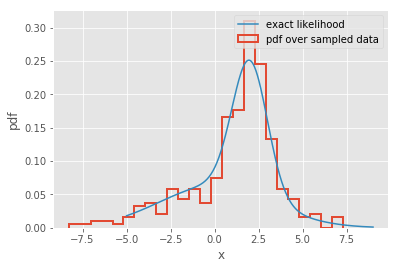

In [31]:
plt.hist(sampled_data, bins=25, histtype="step", linewidth=2, normed=True, label="pdf over sampled data");
plt.plot(xs, likelihood(xs), label="exact likelihood");
plt.xlabel("x")
plt.ylabel("pdf")
plt.legend();

## 2. Exact inference.
Consider a dataset $D$ with three points $x1, x2, x3$. If $p(D,\theta)$ is the joint distribution over the $D, \theta$ (as depicted in the factor graph), then the posterior over $\theta$ can be defined as:

\begin{align}
p(\theta | D) & = \frac{p(D, \theta)}{ \int_{\theta} p(D, \theta) \ d\theta } \tag{2.1} \\
p(D, \theta) & = p(\theta) \prod_{i=1}^3 p(x_i|\theta) \tag{2.2} \\
\end{align}

The full expression for the joint distribution involves products of $p(x|\theta)$ which has 2 normal distributions. For 3 observed points, that gives $8$ different terms to evaluate. For 100, that would be $2^{100}$ terms to evaluate and integrate over. 

## 3. ADF as a solution.
ADF (**Assumed Density Filtering**, which is also called *Gaussian Density Filtering* when the approximating distribution is a Gaussian) proposes to solve this problem by approimating the posterior and simplifying the process by incorporating a single observed data point at a time. [This paper by Manfred Opper](https://www.ki.tu-berlin.de/fileadmin/fg135/publikationen/opper/Op98b.pdf) has a great introduction on the topic in the context of online learning in neural networks. 

The exact joint in [eq 2.1](#2.-Exact-inference.) is a complex sum of products of normal distributions. ADF factorises that joint distribution as a product of simpler terms $t_i(\theta)$. The 0th index represents the prior term. While fewer terms would be better, one should not do it at the cost of increasing complexity, since the whole point of this procedure is to make the posterior calculation tractable. For the clutter problem, Minka defined the terms as the likelihoood as in [eq 1.1](#1.-Problem-statement.). This gives us

\begin{align}
t_0(\theta) & = p(\theta) \\
t_i(\theta) & = p(x_i | \theta) \\
p(D, \theta) & = t_0(\theta) \prod_{i=1}^3 t_i(\theta)
\end{align}



### - Connection with online learning.
With the new factorisation, ADF dictates that the terms are incorporated one at a time into an approximate distribution $q(\theta)$. The exact choice of the distribution is crucial. While the flexibility and expressiveness of the distribution, its modality, ease of computing sufficient statistics, number of sufficient statistics should be kept in mind while selecting one, usually the specifics of the problem and the assumptions over $\theta$ narrow down the candidates. For the clutter problem, Minka chose a Gaussian distribution.
$$ q(\theta) = \mathcal{N}(\theta;\ m_{\theta}, v_{\theta}) $$



Consider a scenario where we already have observed data $D$ and have updated the prior. For a new data point $x$, the posterior will be given by:

$$ p(\theta | D+x) = \frac{p(x | \theta) \ p(\theta | D)}{ \int_{\theta} p(x | \theta) \ p(\theta | D) } \tag{3.1} $$

In the general setting, this update requires holding the entire dataset $D$. To enable online updates, the distribution over the $\theta$ would need to hold a lot of information about the previous data. Such a distribution could then be updated with single data points. The approximate distribution $q(\theta)$ enables this: starting with some initial distribution, ADF incorporates terms $t_i$ one at a time and keeps updating the posterior.

## 4. Update procedure.

To incorporate a term $t_i$ into $q(\theta)$, we obtain the exact posterior *with only that term*, as opposed to [eq 2.1](#2.-Exact-inference.).

$$ \widehat{p}(\theta) = \frac{t_i(\theta) \ q(\theta)}{ \int_{\theta} t_i(\theta) \ q(\theta)\ d\theta } \tag{4.1} $$

This returns a posterior distribution over $\theta$. With this distribution, ADF udpates the *current* approximate distribution $q(\theta)$. The idea is to find an approximate distribution which is "closest" to the newly calculated posterior $\widehat{p}(\theta)$. The measure of "closeness" is given by the KL divergence between $\widehat{p}(\theta)$ and the current $q(\theta)$ : $D(\ \widehat{p}(\theta)\ ||\ q(\theta)\ )$

Since $q(\theta)$ is a known, parameterised distribution, the parameters which give the closest approximation to $\widehat{p}(\theta)$ are those which minimize the KL divergence. As mentioned in the paper, for a normal approximation, the solution boils down to mathcing the first and second moments of $\widehat{p}(\theta)$ and $q(\theta)$. Concretely:

\begin{align}
E_q[\theta] & = E_{\widehat{p}}[\theta] \\
E_q[\theta^2] & = E_{\widehat{p}}[\theta^2]
\end{align}

## 5. q Update equations.
$q(\theta)$ is initally set to 1. Updating it with the prior term $t_0$ requires no approximation. The new $q(\theta)$ is thus defined as $\mathcal{N}(\theta;\ m_{\theta}=0, v_{\theta}=100)$; in effect becoming the prior term. Next, we incorporate the first term $t_1$ using [eq 4.1]().

$$ \widehat{p}(\theta) = \frac{t_1(\theta) \ q(\theta)}{ \int_{\theta} t_1(\theta) \ q(\theta)\ d\theta } $$

The calculations become a lot easier by replacing the denominator as a normalising constant $Z$, which can be evaluated easily following the derivation from [eq 0.1](#--Analytic-computation.).

\begin{align}
Z & = \int_{\theta} t_1(\theta) \ q(\theta)\ d\theta \\
& = \int_{\theta} \{ (1-w)\mathcal{N}(x;\ \theta,\, 1) + w\mathcal{N}(x;\ 0,\,10) \}\mathcal{N}(\theta;\ m_{\theta}=0, v_{\theta}=100) \ d\theta \\
& = (1-w)\int_{\theta} \mathcal{N}(x;\ \theta,\, 1)\ \mathcal{N}(\theta;\ m_{\theta}, v_{\theta})\ d\theta  + w\mathcal{N}(x;\ 0,\,10) \int_{\theta} \mathcal{N}(\theta;\ m_{\theta}, v_{\theta}) \ d\theta \\
& = (1-w)\mathcal{N}(x;\ m_{\theta},\, v_{\theta} + 1) + w\mathcal{N}(x;\ 0,\,10) \\
\end{align}

### 5.1. Update mean.

With $Z$, the first moment can be calculated as follows.

\begin{align}
E_{\widehat{p}}[\theta] & = \int_{\theta} \widehat{p}(\theta)\ \theta\ d\theta \\
& = \frac{1}{Z} (1-w)\int_{\theta} \mathcal{N}(x;\ \theta,\, 1)\ \mathcal{N}(\theta;\ m_{\theta}, v_{\theta})\ \theta \ d\theta  + \frac{1}{Z} w\mathcal{N}(x;\ 0,\,10) \int_{\theta} \mathcal{N}(\theta;\ m_{\theta}, v_{\theta}) \ \theta\ d\theta \\
& = \frac{1}{Z} (1-w)\int_{\theta} \mathcal{N}(x;\ \theta,\, 1)\ \mathcal{N}(\theta;\ m_{\theta}, v_{\theta})\ \theta \ d\theta  + \frac{1}{Z} w\mathcal{N}(x;\ 0,\,10)m_{\theta} \\
& \ Repeating\ the\ steps\ for\ eq\ 0.1\ \ ... \\
& = \frac{1}{Z} (1-w)\ \mathcal{N}(x;\ m_{\theta}, v_{\theta} + 1) \frac{(v_\theta x + m_\theta)}{(v_\theta + 1)}  + \frac{1}{Z} w\mathcal{N}(x;\ 0,\,10)m_{\theta} \\ 
\end{align}

At this point, it helps using the following term $r$ as defined in the paper and in Minka's thesis.

\begin{align}
& r = \frac{1}{Z} (1-w)\ \mathcal{N}(x;\ m_{\theta}, v_{\theta} + 1) \\
=> E_{\widehat{p}}[\theta] & = r \frac{(v_\theta x + m_\theta)}{(v_\theta + 1)}  + (1 - r) m_{\theta} \\
& = m_{\theta} + r\frac{(v_{\theta}x + m_{\theta})}{(v_{\theta} + 1)} - rm_{\theta} \\
& = m_{\theta} + r\frac{v_{\theta}x + m_{\theta} - m_{\theta} v_{\theta} - m_{\theta}}{v_{\theta} + 1}  \\
& = m_{\theta} + v_{\theta}r \frac{x - m_{\theta}}{v_{\theta} + 1}\\
\end{align}

The second moment can also be calculated along the same lines, but this is too specific to the clutter problem. Chapter 3 of Minka's thesis states a few Gaussian relations which will be true for any likelihood function $t(\theta)$. Pasting the image below. ![](media/gaussian_relations_photo.png)

### 5.2. Update variance.

From [eq 5.1.1](), for the clutter problem, we have:

\begin{align}
\nabla_m & \equiv \frac{E_{\widehat{p}}[\theta]}{v_{\theta}} - \frac{m_{\theta}}{v_{\theta}} \\
& = r\frac{x - m_{\theta}}{v_{\theta} + 1} \\ \\
\nabla_v & \equiv \nabla_v logZ \\
& = \frac{1}{Z}\frac{\partial Z}{\partial v} \\
& = \frac{1-w}{Z} \frac{\partial}{\partial v_{\theta}} \mathcal{N}(x;\ m_{\theta}\ , v_{\theta} + 1) + 0 \\
& = \frac{1-w}{Z} \frac{\partial}{\partial v_{\theta}} \Big\{  \frac{1}{\sqrt{2\pi(v_{\theta} + 1)}} \exp \Big( {- \frac{(x - m_{\theta})^2}{2(v_{\theta} + 1)}} \Big) \Big\} \\
& = -\frac{1}{2(v_{\theta} + 1)} \frac{(1-w)}{Z} \frac{1}{\sqrt{2\pi(v_{\theta} + 1)}}  \exp \Big( {- \frac{(x - m_{\theta})^2}{2(v_{\theta} + 1)}} \Big)    +    \frac{(1-w)}{Z}  \frac{1}{\sqrt{2\pi(v_{\theta} + 1)}}  \exp \Big( {- \frac{(x - m_{\theta})^2}{2(v_{\theta} + 1)}} \Big) \frac{(x - m_{\theta})^2}{2 (v_{\theta} + 1)^2}  \\
& = -\frac{1}{2(v_{\theta} + 1)} \frac{(1-w)}{Z} \mathcal{N}(x;\ m_{\theta},\, v_{\theta} + 1)    +    \frac{(1-w)}{Z}  \mathcal{N}(x;\ m_{\theta},\, v_{\theta} + 1) \frac{(x - m_{\theta})^2}{2 (v_{\theta} + 1)^2}  \\
& = -\frac{r}{2(v_{\theta} + 1)} +  \frac{r (x - m_{\theta})^2}{2 (v_{\theta} + 1)^2}
\end{align}

With $\nabla_m$ and $\nabla_v$, the updated variance for $q(\theta)$ can be calculated from equation 3.19 in the image:

\begin{align}
v_{\theta}^{new} & = E_{\widehat{p}}[\theta^2] - E_{\widehat{p}}[\theta]^2 \\
& = v_{\theta} - v_{\theta}^2(\nabla_m^2 - 2\nabla_v) \\
& = v_{\theta} - v_{\theta}^2\Big(r^2 \Big( \frac{x - m_{\theta}}{v_{\theta} + 1} \Big)^2 + \frac{r}{v_{\theta} + 1} - \frac{r (x - m_{\theta})^2}{(v_{\theta} + 1)^2}  \Big) \\
& = v_{\theta} - r\frac{v_{\theta}^2}{v_{\theta} + 1}  - v_{\theta}^2 r \frac{(x - m_{\theta})^2}{(v_{\theta} + 1)^2} (r  - 1)  \\
& = v_{\theta} - r\frac{v_{\theta}^2}{v_{\theta} + 1}  + r(1 - r) \frac{v_{\theta}^2 (x - m_{\theta})^2}{(v_{\theta} + 1)^2} \\
\end{align}

### 5.3. Update algorithm.
1. Initialise $q(\theta) = 1$

2. Merge prior $t_0(\theta)$ into $q(\theta)$. $m_{\theta}$ becomes $0$, $v_{\theta}$ becomes $100$, subsuming the prior distribution.

3. For every sampled datapoint $x_i$:

    3.1. $ m_{\theta}^{new} = m_{\theta} + v_{\theta}r_i \frac{x_i - m_{\theta}}{v_{\theta} + 1} $
    
    3.2. $ v_{\theta}^{new} = v_{\theta} - r_i\frac{v_{\theta}^2}{v_{\theta} + 1}  + r_i(1 - r_i) \frac{v_{\theta}^2 (x_i - m_{\theta})^2}{(v_{\theta} + 1)^2}$

## 6. Applying with data.

In [33]:
m_theta, v_theta = 0.0, 100.0

moments_list = []

for ix, xi in enumerate(sampled_data):
    ai = 0.5 * gaussian_pdf(xi, m_theta, v_theta+1)
    bi = 0.5 * gaussian_pdf(xi, 0, 10)
    zi = ai + bi
    ri = ai / zi
    
    mnew = m_theta + (v_theta * ri)*(xi - m_theta)/(v_theta + 1)
    vnew = v_theta - (ri * v_theta**2)/(v_theta + 1) + (ri*(1 - ri))*np.square(v_theta*(xi - m_theta)/(v_theta + 1))
    
    m_theta = mnew
    v_theta = vnew
    
    moments_list.append((ix+1, m_theta, v_theta))

In [63]:
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML

rc('animation', html='html5')

In [114]:
def display_animation(anim):
    plt.close(anim._fig)
    return HTML(anim_to_gif(anim))

fig = plt.figure()
ax = plt.axes(xlim=(-5, 9), ylim=(0, 5))
line, = ax.plot([], [], lw=2)


def init():
    line.set_data([], [])
    return line,

def animate((ix, m, v)):
    x = np.linspace(-5, 9, 250)
    y = gaussian_pdf(x, m, v)
    line.set_data(x, y)
    ax.set_title("Data points: %d"%ix)
    return line,

plt.close()
ax.set_ylabel("density")
ax.set_xlabel(r"$\theta$ possibilities")

anim = animation.FuncAnimation(fig, animate, 
                               init_func=init, frames=moments_list, interval=50, blit=True)
anim.save("media/theta_adf.gif", writer="imagemagick")

We take 300 samples from the distribution and follow the algorithm to update $m_{\theta}$ and $v_{\theta}$. The sample mean is 1.134 . As apparent from the gif, $m_{\theta}$ starts out way towards the left with a lot of uncertainity, but it soon converges near the true mean(i.e. 2); $m_{\theta}$ after 300 samples is 2.137
![adf-gif](media/theta_adf.gif)